In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
plt.style.use(['ggplot'])

In [43]:
# importing the data
data = pd.read_csv("FoDS-A1.csv", names = ["X1","X2","Y"], header=0)

# Data Preprocessing

Preprocessing the data involves:

- `Normalizing` the data:<br>
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <font size="4"> X = $\frac{ X_{} - X_{min} }{X_{max} - X_{min}}$ </font>
<br>
<br>                 
- `Shuffling` the data
<br>
<br>
- `Splitting` the data to test and train 

In [44]:
def normalize(data):
    data_min = data.min()
    data_max = data.max()
    data["X1"] = (data["X1"] - data_min[0])/(data_max[0]-data_min[0])
    data["X2"] = (data["X2"] - data_min[1])/(data_max[1]-data_min[1])
    data["Y"] = (data["Y"] - data_min[2])/(data_max[2]-data_min[2])

In [45]:
def split(data,fraction = 0.7):
    
    shuffled_data = data.sample(frac=1, random_state=0) # Shuffling the dataset
    split_index = int(fraction * len(data)) # Finding split index
    
    # Spliting the dataset 
    train= shuffled_data[:split_index]
    test = shuffled_data[split_index:]
    return train.reset_index(drop=True), test.reset_index(drop=True)

In [46]:
def generate_vectors(train_X, degree=9):
    total_terms = int(((degree+1)*(degree+2))/2)
    terms = np.zeros((total_terms,train_X.shape[0]))
    
    
    for i in range(train_X.shape[0]):

        current_x1 = train_X[i][0]
        current_x2 = train_X[i][1]
        m = 0
        part_x1 = 1
        part_x2 = 1
        
        for j in range(degree+1):
            for k in range(degree-j+1):
                terms[m][i] = part_x1 * part_x2
                m += 1
                part_x1 = part_x1 * current_x1 
            
            part_x2 = part_x2 * current_x2
            part_x1 = 1
            
    W = np.zeros(total_terms)
                
    return terms.T, W

In [72]:
def calculate_cost_ridge(W, X, Y, penalty):

    m=len(Y)
    cost = (np.sum(np.square(np.dot(X,W) - Y))) * (1/(2*m))
    cost += (penalty * np.dot(W[1:].T, W[1:]))* (1/(2*m))
    return cost

In [48]:
def calculate_cost_lasso(W, X, Y, penalty):

    m=len(Y)
    cost = (np.sum(np.square(np.dot(X,W) - Y))) * (1/(2*m))
    cost += penalty * np.sum(np.absolute(W[1:])) * (1/m)
    return cost

In [49]:
def gradient_descent_ridge(X, Y, W, penalty, learning_rate=0.01, iterations=1000):

    cost_history = np.zeros(iterations)
    m = len(Y)
    for it in range(iterations):
        
        prediction = np.dot(X, W)         
        updated_W0 = W[0] - np.multiply((X.T.dot(prediction - Y)), learning_rate/m)[0]
        W[1:] = W[1:] - np.multiply((X.T.dot(prediction - Y)[1:] + np.multiply(W[1:], penalty)), learning_rate/m)
        W[0] = updated_W0
        cost_history[it]  = calculate_cost_ridge(W, X, Y, penalty)
        
    return W, cost_history

In [50]:
def gradient_descent_lasso(X, Y, W,  penalty, learning_rate=0.0001, iterations=1000):

    cost_history = np.zeros(iterations)
    m = len(Y)
    for it in range(iterations):
        
        prediction = np.dot(X, W)         
        updated_W0 = W[0] - np.multiply((X.T.dot(prediction - Y)), learning_rate/m)[0]
        W[1:] = W[1:] - np.multiply((X.T.dot(prediction - Y)[1:] + np.multiply(np.divide(W[1:], np.absolute(W[1:])), penalty)), learning_rate/m)
        W[0] = updated_W0
        cost_history[it]  = calculate_cost_lasso(W, X, Y, penalty)
        
    return W, cost_history

In [51]:
def stochastic_gradient_descent_ridge(X, Y, W, penalty, learning_rate=0.01, iterations=10):

    m = len(Y)
    m = int(m / 10)
    cost_history = np.zeros(iterations)
    
    for it in range(iterations):
        cost = 0.0
        for i in range(m):
            rand_int = np.random.randint(0,m)
            X_i = X[rand_int:rand_int+1]
            Y_i = Y[rand_int:rand_int+1]

            prediction = np.dot(X_i,W)
            updated_W0 = W[0] - np.multiply((X_i.T.dot(prediction - Y_i)), learning_rate/m)[0]
            W[1:] = W[1:] - np.multiply((X_i.T.dot(prediction - Y_i)[1:] + np.multiply(W[1:], penalty)), learning_rate/m)
            W[0] = updated_W0
            
            cost += calculate_cost_ridge(W,X_i,Y_i, penalty)
        cost_history[it]  = cost
        
    return W, cost_history

In [52]:
def stochastic_gradient_descent_lasso(X, Y, W, penalty, learning_rate=0.01, iterations=10):

    m = len(Y)
    m = int(m / 10)
    cost_history = np.zeros(iterations)
    
    for it in range(iterations):
        cost =0.0
        for i in range(m):
            rand_int = np.random.randint(0,m)
            X_i = X[rand_int:rand_int+1]
            Y_i = Y[rand_int:rand_int+1]

            prediction = np.dot(X_i,W)
            updated_W0 = W[0] - np.multiply((X_i.T.dot(prediction - Y_i)), learning_rate/m)[0]
            W[1:] = W[1:] - np.multiply((X_i.T.dot(prediction - Y_i)[1:] + np.multiply(np.divide(W[1:], np.absolute(W[1:])), penalty)), learning_rate/m)
            W[0] = updated_W0
            
            cost += calculate_cost_lasso(W,X_i,Y_i, penalty)
        cost_history[it]  = cost
        
    return W, cost_history

In [53]:
def errorloop(cost_history):
    for it in range(len(cost_history)):
        if it%500==0: print(cost_history[it])

In [54]:
def RMSerror(final_error):
    return math.sqrt(2*final_error)

In [55]:
def model_ridge(X, Y, learning_rate, iterations, penalty, degree):
    train_X_terms, W_gd = generate_vectors(X, degree)
    W_gd, cost_history_gd = gradient_descent_ridge(train_X_terms, Y, W_gd, penalty, learning_rate, iterations)
    
    #print(W_gd)
    print('Final cost/MSE:  {:0.3f}'.format(cost_history_gd[-1]))
    print('-------------------------------------------------------------------')
    errorloop(cost_history_gd)

    train_X_terms, W_sgd = generate_vectors(X, degree)
    W_sgd, cost_history_sgd = stochastic_gradient_descent_ridge(train_X_terms, Y, W_sgd, penalty, learning_rate, iterations)

    #print(W_sgd)
    print('Final cost/MSE:  {:0.3f}'.format(cost_history_sgd[-1]))
    print('-------------------------------------------------------------------')
    errorloop(cost_history_sgd)
    
    return train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, iterations, degree
    

In [56]:
def model_lasso(X, Y, learning_rate, iterations, penalty, degree):
    train_X_terms, W_gd = generate_vectors(X, degree)
    W_gd, cost_history_gd = gradient_descent_lasso(train_X_terms, Y, W_gd+1, penalty, learning_rate, iterations)
    
    #print(W_gd)
    print('Final cost/MSE:  {:0.3f}'.format(cost_history_gd[-1]))
    print('-------------------------------------------------------------------')
    errorloop(cost_history_gd)

    train_X_terms, W_sgd = generate_vectors(X, degree)
    W_sgd, cost_history_sgd = stochastic_gradient_descent_lasso(train_X_terms, Y, W_sgd+1, penalty, learning_rate, iterations)

    #print(W_sgd)
    print('Final cost/MSE:  {:0.3f}'.format(cost_history_sgd[-1]))
    print('-------------------------------------------------------------------')
    errorloop(cost_history_sgd)
    
    return train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, iterations, degree

In [57]:
def cost_plotter(n_iter, cost_history_gd, cost_history_sgd, degree):
    figure, axis = plt.subplots(1,2, figsize=(15,8))
    figure.suptitle("Model degree = "+str(degree),  fontsize="x-large", fontweight ="bold")

    axis[0].scatter(range(n_iter),cost_history_gd)
    axis[0].set_title("Gradient Descent")
    axis[0].set_xlabel("J(theta)")
    axis[0].set_ylabel("Iterations")


    axis[1].scatter(range(n_iter),cost_history_sgd)
    axis[1].set_title("Stochastic_Gradient Descent")
    axis[1].set_xlabel("J(theta)")
    axis[1].set_ylabel("Iterations")

    plt.show()

In [58]:
normalize(data)
train_data, test_data = split(data)

In [59]:
X1 = np.array(train_data['X1'])
X2 = np.array(train_data['X2'])
Y = np.array(train_data['Y'])
X11 = np.array(test_data['X1'])
X21 = np.array(test_data['X2'])
Y1 = np.array(test_data['Y'])

In [63]:
v1 = np.ones(5)
v2 = np.ones(5)
v3 = np.ones(5)
v4 = np.ones(5)
lam = np.ones(5)

In [76]:
#lambda = 0
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_lasso(l, Y, 0.01, 20000, math.exp(0), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v3[0]=math.sqrt(calculate_cost_lasso(W_gd, train_X_terms, Y1, math.exp(0)))

train_X_terms, A = generate_vectors(l, degree)
v4[0]=math.sqrt(calculate_cost_lasso(W_sgd, train_X_terms, Y1, math.exp(0)))

lam[0]=0
v1[0]=math.sqrt(cost_history_gd[-1])
v2[0]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.019
-------------------------------------------------------------------
71.70742057742586
0.2151864802113932
0.08161310638026122
0.04514029954210386
0.03441780977770171
0.030732265043427458
0.029053955966202666
0.027972619597920686
0.02711713147902286
0.026372280653011365
0.025708927328456987
0.025121008024707302
0.024604997487790777
0.024134613511925074
0.02371732926057051
0.023335186167699418
0.02298013946575306
0.02264847566482861
0.022348613323967793
0.022072702990357844
0.021814737787516802
0.021571291958805472
0.02133923128780907
0.021123282664252067
0.020921304929051972
0.020727737970390223
0.020550772250231206
0.02038139619402374
0.020221930419036385
0.020068535145735453
0.01992457929264931
0.019785774263558674
0.019662526583075227
0.019545314113371494
0.019440423680019896
0.019339406966647075
0.01924237272043624
0.01915383059625295
0.019067849561401354
0.01898408008952064
Final cost/MSE:  6.471
----------------------------------------------------------------

In [65]:
#lambda = -5
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_lasso(l, Y, 0.01, 20000, math.exp(-5), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v3[1]=math.sqrt(calculate_cost_lasso(W_gd, train_X_terms, Y1, math.exp(-5)))

train_X_terms, A = generate_vectors(l, degree)
v4[1]=math.sqrt(calculate_cost_lasso(W_sgd, train_X_terms, Y1, math.exp(-5)))

lam[1]=-5
v1[1]=math.sqrt(cost_history_gd[-1])
v2[1]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
71.66351317051823
0.2114801796932364
0.07895328566736845
0.040862992072381275
0.029185475420860904
0.025147278651114265
0.02336817095085675
0.02229978682407538
0.021491856222922656
0.020809174649950194
0.02020748617737563
0.019669210653453374
0.019184957506174376
0.01874816502238008
0.018353614982225066
0.01799662710705506
0.017673133250278566
0.017379585652087554
0.017112817578350526
0.016869898317054238
0.01664829993553347
0.0164457708954267
0.01626032217049365
0.016090157785307004
0.01593367454688645
0.015789454295684863
0.015656238263259223
0.01553293719703514
0.015418498895189573
0.015312058533810072
0.01521282104543659
0.015120041456607534
0.015033081390299281
0.014951374703018473
0.0148744160948689
0.014801759602850746
0.014733005111200325
0.014667783230676164
0.014605772482455068
0.014546685470236341
Final cost/MSE:  4.194
------------------------------------------------------------------

In [66]:
#lambda = -10
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_lasso(l, Y, 0.01, 20000, math.exp(-10), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v3[2]=math.sqrt(calculate_cost_lasso(W_gd, train_X_terms, Y1, math.exp(-10)))

train_X_terms, A = generate_vectors(l, degree)
v4[2]=math.sqrt(calculate_cost_lasso(W_sgd, train_X_terms, Y1, math.exp(-10)))

lam[2]=-10
v1[2]=math.sqrt(cost_history_gd[-1])
v2[2]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
71.6632173220652
0.2114546458662171
0.0789345612825283
0.04083287542861278
0.029147806951539568
0.02510626602335059
0.023325433125306362
0.02225608373558106
0.0214474987607083
0.02076433384189161
0.02016228295737996
0.01962374269355606
0.01913930791041703
0.018702405716624803
0.01830770304547183
0.017950600004598662
0.017627044414923767
0.01733344107795726
0.017066592171890282
0.016823650009507574
0.016602079272221324
0.016399621831390016
0.016214266270704818
0.016044220675379604
0.015887888350949037
0.015743846661652565
0.015610827793307766
0.01548770199997478
0.015373461770142729
0.015267209079524736
0.015168143197131048
0.015075549726576012
0.014988791394659532
0.014907299674049487
0.014830567155283789
0.014758140854561567
0.014689616284983432
0.014624632128504943
0.014562865419539998
0.0145040275084857
Final cost/MSE:  1.431
-------------------------------------------------------------------


In [67]:
#lambda = -15
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_lasso(l, Y, 0.01, 20000, math.exp(-15), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v3[3]=math.sqrt(calculate_cost_lasso(W_gd, train_X_terms, Y1, math.exp(-15)))

train_X_terms, A = generate_vectors(l, degree)
v4[3]=math.sqrt(calculate_cost_lasso(W_sgd, train_X_terms, Y1, math.exp(-15)))

lam[3]=-15
v1[3]=math.sqrt(cost_history_gd[-1])
v2[3]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
71.66321532865389
0.21145447379934368
0.07893443509400709
0.04083267245668554
0.029147553039716768
0.025105989541906217
0.023325144958192923
0.02225578901517628
0.021447199586071372
0.020764031367440573
0.020161977999300446
0.01962343591104875
0.019138999864411775
0.018702096892663642
0.018307393193123273
0.017950289336371952
0.017626733312322316
0.017333129617924405
0.0170662801260848
0.01682333776995034
0.01660176718090403
0.016399310185739042
0.01621395526707156
0.016043910433065443
0.015887579087811552
0.015743538565254168
0.015610521024395668
0.015487396449933624
0.015373157517482432
0.015266906133124473
0.015167841448251628
0.015075249192132314
0.014988492181506071
0.014907001872805022
0.014830270842208147
0.014757846093223908
0.01468932310022923
0.01462434050645241
0.014562575404141024
0.014503739135119435
Final cost/MSE:  1.647
-------------------------------------------------------------

In [68]:
#lambda = -20
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_lasso(l, Y, 0.01, 20000, math.exp(-20), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v3[4]=math.sqrt(calculate_cost_lasso(W_gd, train_X_terms, Y1, math.exp(-20)))

train_X_terms, A = generate_vectors(l, degree)
v4[4]=math.sqrt(calculate_cost_lasso(W_sgd, train_X_terms, Y1, math.exp(-20)))

lam[4]=-20
v1[4]=math.sqrt(cost_history_gd[-1])
v2[4]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
71.66321531522239
0.21145447263996486
0.07893443424375335
0.04083267108906803
0.029147551328867014
0.025105987678981926
0.023325143016529
0.02225578702935455
0.02144719757023525
0.020764029329368536
0.020161975944491938
0.019623433843945475
0.0191389977887933
0.018702094811801573
0.018307391105331174
0.017950287243080797
0.01762673121610318
0.01733312751929656
0.017066278023508456
0.016823335666066964
0.016601765078017982
0.01639930808585438
0.016213953171513747
0.016043908342635717
0.015887577003977877
0.01574353648928037
0.015610518957364908
0.015487394391120781
0.01537315546740943
0.015266904091854503
0.0151678394150538
0.015075247167115299
0.01498849016538994
0.01490699986620044
0.014830268845629015
0.014757844107098633
0.014689321124730051
0.014624338541480724
0.014562573449993033
0.014503737192033597
Final cost/MSE:  1.860
-------------------------------------------------------------------


In [82]:
print(v1)
print(v2)
print(v3)
print(v4)

[0.13748627 0.12037598 0.12019971 0.12019852 0.12019851]
[2.54391132 2.04791971 1.19621349 1.2835396  1.3639334 ]
[0.15467369 0.11660403 0.11613709 0.11613392 0.1161339 ]
[0.23802621 0.14153653 0.11810831 0.11865574 0.11870145]


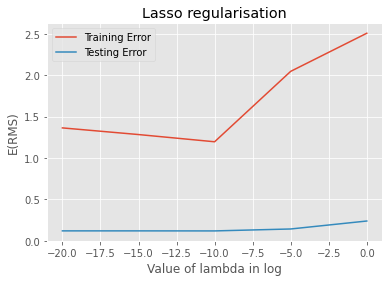

In [69]:
# Function to plot  
plt.plot(lam, v2, label ='Training Error')
plt.plot(lam, v4, label ='Testing Error')

plt.xlabel("Value of lambda in log")
plt.ylabel("E(RMS)")
  
# Function add a legend  
plt.legend()

plt.title("Lasso regularisation")
  
# function to show the plot
plt.show()

In [70]:
v5 = np.ones(5)
v6 = np.ones(5)
v7 = np.ones(5)
v8 = np.ones(5)
lamb = np.ones(5)

In [74]:
#lambda = 0
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_ridge(l, Y, 0.01, 20000, math.exp(0), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v7[0]=math.sqrt(calculate_cost_ridge(W_gd, train_X_terms, Y1, math.exp(0)))

train_X_terms, A = generate_vectors(l, degree)
v8[0]=math.sqrt(calculate_cost_ridge(W_sgd, train_X_terms, Y1, math.exp(0)))

lamb[0]=0
v5[0]=math.sqrt(cost_history_gd[-1])
v6[0]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.016
-------------------------------------------------------------------
0.17621255817317155
0.046539198656280346
0.03910715980773724
0.03519504848448701
0.032585236027759784
0.03056311081413836
0.028874247436912654
0.027415877604235365
0.026138230213303533
0.02501169705623586
0.024015357615184908
0.02313271420197975
0.02234997164858092
0.021655260173048217
0.021038228214455914
0.020489791192845896
0.020001952774648113
0.019567664569687573
0.019180709488105293
0.018835601791639237
0.018527500148202317
0.018252131440483585
0.018005723761699143
0.0177849473904621
0.017586862752133992
0.017408874521690078
0.017248691135606547
0.01710428907200423
0.01697388133604067
0.016855889654804498
0.016748919944742702
0.016651740666267748
0.01656326372563007
0.016482527624187934
0.016408682590519877
0.016340977461974104
0.016278748109727702
0.01622140722567093
0.016168435310819924
0.016119372723831245
Final cost/MSE:  6.353
-----------------------------------------------------------

In [75]:
#lambda = -5
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_ridge(l, Y, 0.01, 20000, math.exp(-5), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v7[1]=math.sqrt(calculate_cost_ridge(W_gd, train_X_terms, Y1, math.exp(-5)))

train_X_terms, A = generate_vectors(l, degree)
v8[1]=math.sqrt(calculate_cost_ridge(W_sgd, train_X_terms, Y1, math.exp(-5)))

lamb[1]=-5
v5[1]=math.sqrt(cost_history_gd[-1])
v6[1]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
0.1762125450168981
0.04649079049568522
0.03899810863170115
0.03502501814355374
0.03235355617025402
0.030266421830436988
0.028508512654627123
0.0269776868157518
0.025625281275438217
0.024422851362880943
0.02335052185131404
0.022392668103018692
0.021536192268109877
0.020769761884280504
0.02008342430896287
0.019468377442764792
0.018916811206443434
0.018421785021517013
0.017977126453021245
0.01757734422102476
0.017217552144514
0.01689340203652611
0.016601024236766654
0.016336974801413627
0.01609818855753814
0.01588193735070265
0.01568579290265434
0.015507593766408756
0.015345415925134345
0.0151975466323565
0.01506246113583857
0.014938801967121877
0.014825360513848753
0.014721060623210757
0.01462494401262047
0.014536157288393102
0.01445394039518605
0.014377616338484863
0.014306582039809109
0.014240300199780025
Final cost/MSE:  3.075
-------------------------------------------------------------------
1

In [77]:
#lambda = -10
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_ridge(l, Y, 0.01, 20000, math.exp(-10), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v7[2]=math.sqrt(calculate_cost_ridge(W_gd, train_X_terms, Y1, math.exp(-10)))

train_X_terms, A = generate_vectors(l, degree)
v8[2]=math.sqrt(calculate_cost_ridge(W_sgd, train_X_terms, Y1, math.exp(-10)))

lamb[2]=-10
v5[2]=math.sqrt(cost_history_gd[-1])
v6[2]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
0.17621254492825184
0.046490463324909484
0.038997370298967965
0.03502386500403762
0.03235198208414651
0.03026440208103829
0.028506017629326228
0.02697469098355762
0.025621766591848432
0.0244188077539814
0.023345946487082134
0.0223875642776802
0.02153056823638378
0.020763629789102393
0.020076799244497175
0.019461276658306943
0.018909253441736627
0.018413789958876617
0.01796871427076067
0.017568535233509097
0.017208366515629677
0.016883859554962643
0.01659114414305524
0.016326775658078697
0.016087688154969807
0.015871152642452042
0.015674739964803324
0.015496287776484659
0.01533387115674546
0.015185776462329319
0.015050478061156282
0.014926617629407229
0.014812985729512854
0.01470850541771198
0.014612217657552022
0.014523268340350347
0.01444089673556194
0.014364425213507965
0.014293250100278694
0.014226833540070321
Final cost/MSE:  2.012
-------------------------------------------------------------

In [78]:
#lambda = -15
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_ridge(l, Y, 0.01, 20000, math.exp(-15), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v7[3]=math.sqrt(calculate_cost_ridge(W_gd, train_X_terms, Y1, math.exp(-15)))

train_X_terms, A = generate_vectors(l, degree)
v8[3]=math.sqrt(calculate_cost_ridge(W_sgd, train_X_terms, Y1, math.exp(-15)))

lamb[3]=-15
v5[3]=math.sqrt(cost_history_gd[-1])
v6[3]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
0.17621254492765454
0.046490461120404676
0.038997365323959234
0.03502385723390295
0.032351971477441385
0.030264388471126603
0.028506000816567626
0.026974670795806403
0.02562174290740275
0.024418780504850246
0.023345915654092192
0.022387529882933715
0.02153053033541833
0.02076358846366627
0.020076754596235924
0.019461228803398886
0.01890920250641356
0.018413736075731407
0.017968657575737373
0.017568475863476686
0.017208304606450463
0.016883795239977167
0.01659107755191595
0.016326706915874165
0.016087617381589724
0.015871079952150455
0.015674665465924203
0.015496211571319238
0.015333793341495488
0.015185697127154724
0.015050397290288831
0.014926535501315171
0.014812902317103676
0.014708420788563055
0.014612131874160236
0.014523181460393823
0.014440808812168018
0.014364336295522865
0.014293160232535167
0.014226742763650418
Final cost/MSE:  1.659
-----------------------------------------------------

In [79]:
#lambda = -20
l = np.c_[X1, X2]
train_X_terms, W_gd, cost_history_gd, W_sgd, cost_history_sgd, n_iter, degree = model_ridge(l, Y, 0.01, 20000, math.exp(-20), 9)

l = np.c_[X11, X21]
train_X_terms, A = generate_vectors(l, degree)
v7[4]=math.sqrt(calculate_cost_ridge(W_gd, train_X_terms, Y1, math.exp(-20)))

train_X_terms, A = generate_vectors(l, degree)
v8[4]=math.sqrt(calculate_cost_ridge(W_sgd, train_X_terms, Y1, math.exp(-20)))

lamb[4]=-20
v5[4]=math.sqrt(cost_history_gd[-1])
v6[4]=math.sqrt(cost_history_sgd[-1])

Final cost/MSE:  0.014
-------------------------------------------------------------------
0.1762125449276505
0.04649046110555082
0.03899736529043788
0.03502385718154819
0.03235197140597393
0.030264388379423697
0.028506000703284084
0.02697467065978231
0.02562174274781808
0.024418780321246877
0.02334591544634093
0.022387529651183482
0.021530530080043315
0.020763588185217306
0.020076754295397885
0.019461228480954582
0.018909202163213516
0.018413735712669035
0.017968657193728685
0.01756847546344387
0.017208304189308944
0.016883794806625385
0.016591077103227502
0.016326706452691908
0.016087616904721453
0.01587107946236601
0.015674664963953602
0.015496211057851716
0.015333792817179259
0.015185696592597261
0.01505039674605769
0.014926534947939054
0.014812901755073864
0.014708420218334866
0.014612131296154771
0.014523180874999706
0.014440808219743228
0.014364335696396533
0.014293159627009376
0.014226742152001964
Final cost/MSE:  1.388
----------------------------------------------------------

In [83]:
print(v5)
print(v6)
print(v7)
print(v8)

[0.12678289 0.11907314 0.11901603 0.11901565 0.11901565]
[2.52053828 1.75348753 1.41848377 1.28792899 1.17810535]
[0.13166501 0.1156507  0.11552498 0.11552413 0.11552413]
[0.22958886 0.13386399 0.11746093 0.11695846 0.11705848]


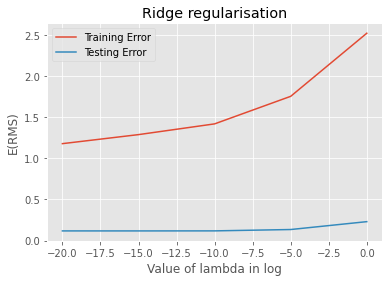

In [81]:
# Function to plot  
plt.plot(lamb, v6, label ='Training Error')
plt.plot(lamb, v8, label ='Testing Error')

plt.xlabel("Value of lambda in log")
plt.ylabel("E(RMS)")
  
# Function add a legend  
plt.legend()

plt.title("Ridge regularisation")
  
# function to show the plot
plt.show()